# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

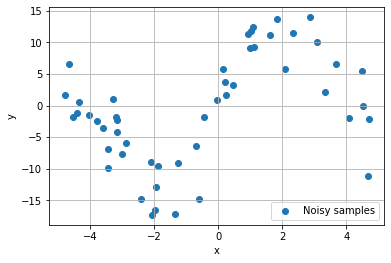

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

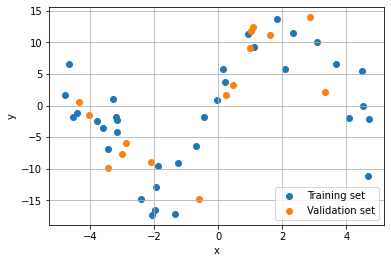

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

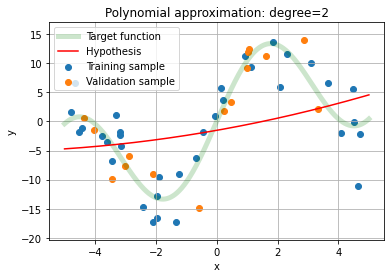

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

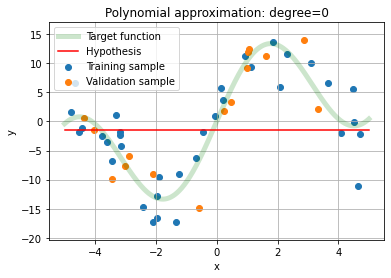

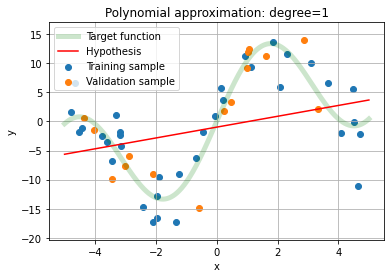

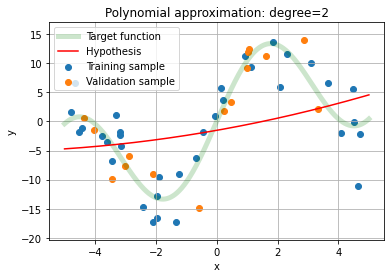

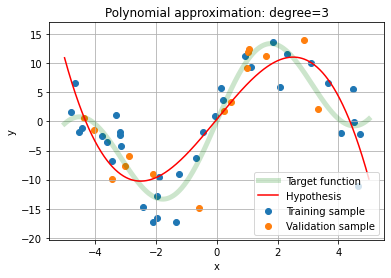

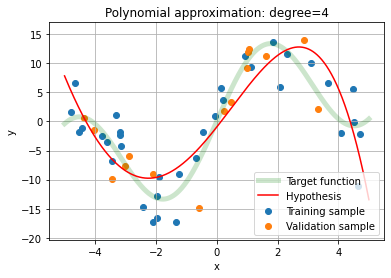

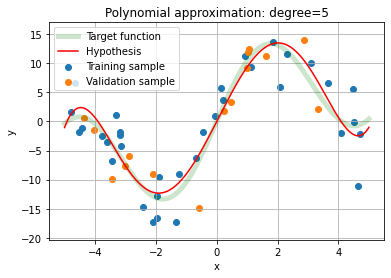

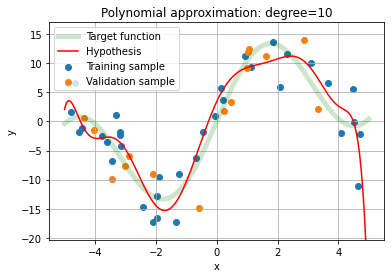

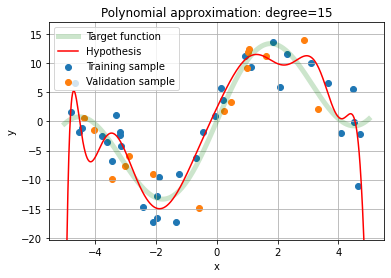

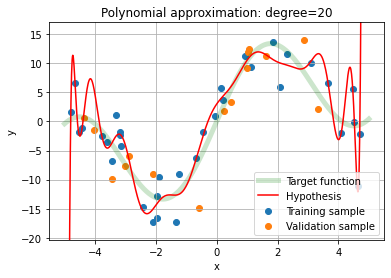

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

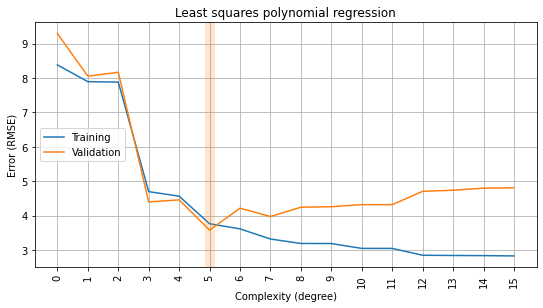

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

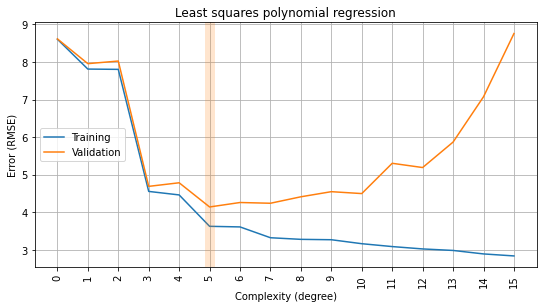

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

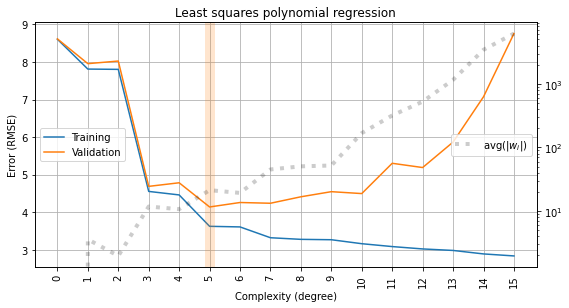

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

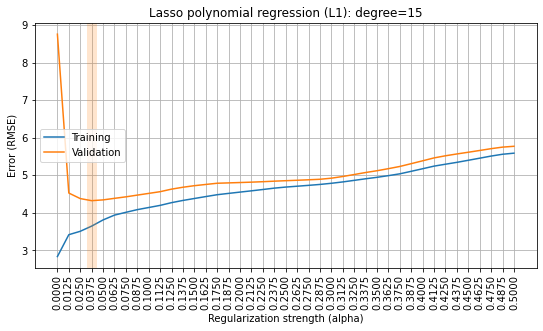

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

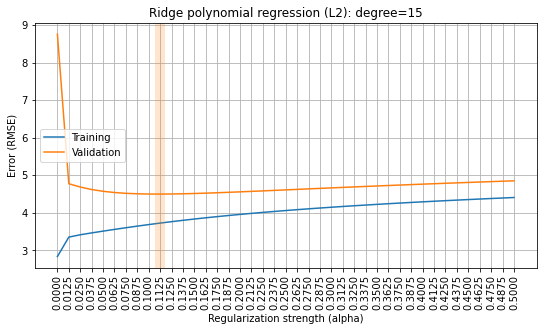

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [21]:
X = X_diabetes
y = y_diabetes
degrees_poly = np.arange(start=1, stop=16, step=1)
print("X columns : ", X.columns)
print("Polynomial degrees : ", degrees_poly)

X columns :  Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')
Polynomial degrees :  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)
poly_features=['age', 'sex', 'bmi', 'bp', 's1', 's2']
other_features = ['s3', 's4', 's5', 's6']
rmse_train, rmse_valid = [], []
for degree in degrees_poly:
    poly_reg = PolynomialFeatures(degree=degree,include_bias=False)
    X_train_poly = poly_reg.fit_transform(X_train[poly_features])
    X_valid_poly = poly_reg.fit_transform(X_valid[poly_features])
    X_train_full = np.concatenate((X_train_poly,X_train[other_features]),axis = 1)
    X_valid_full = np.concatenate((X_valid_poly,X_valid[other_features]),axis = 1)
    pol_reg = LinearRegression()
    pol_reg.fit(X_train_full, y_train)
    y_pred_v_poly=pol_reg.predict(X_valid_full)
    y_pred_t_poly=pol_reg.predict(X_train_full)
    rmse_train_poly = np.sqrt(mean_squared_error(y_pred_t_poly, y_train))
    rmse_valid_poly = np.sqrt(mean_squared_error(y_pred_v_poly,y_valid,))
    rmse_train.append(rmse_train_poly)
    rmse_valid.append(rmse_valid_poly)
print(rmse_train, rmse_valid)

[54.074408724527814, 52.01594705433475, 47.71096927740895, 33.04025622137287, 4.89526964256906e-10, 4.971254942679278e-10, 4.989476669106768e-10, 5.008493431289861e-10, 5.000615757471225e-10, 5.008253383649718e-10, 5.037274158531946e-10, 5.057437927538942e-10, 5.11075474395391e-10, 5.135322266844912e-10, 5.113085002363767e-10] [53.12003915269996, 51.15951201309319, 58.71975910197329, 151.85181210858326, 2905.8211259271375, 2147.445180874547, 2143.605746214755, 2143.4170863322715, 2143.408486256226, 2143.40815219224, 2143.408135932256, 2143.408135302234, 2143.4081352747435, 2143.4081352737303, 2143.408135273682]


In [23]:
len(rmse_valid)

15

In [24]:
range_axis = np.arange(start=1, stop=16, step=1)
range_axis

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

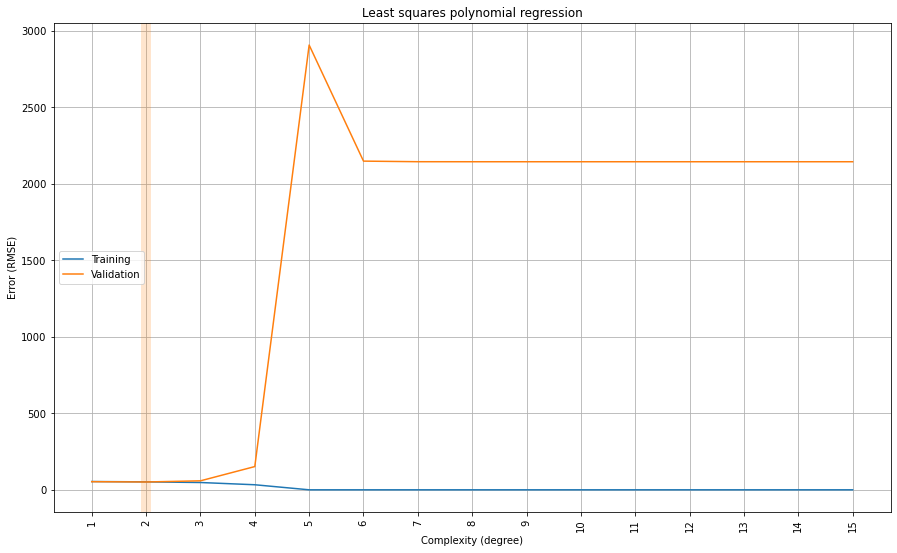

In [25]:
def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(15, 9))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
plot_fitting_graph(range_axis, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', title='Least squares polynomial regression')

In [26]:
degrees_poly[np.argmin(rmse_valid)]

2

#### Summary
The optimal polynomial degree for feature engineering is 2. Starting from degree 3, we can observe an increase in RMSE. It peaks at the degree of 5 and indicates extreme overfitting. A further increase in complexity degree hits a plateau of RMSE. With such a high degree of flexibility, the model does its best to account for every training point and fails to predict data with other inputs.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=SEED)
poly_features=['age', 'sex', 'bmi', 'bp', 's1', 's2']
other_features = ['s3', 's4', 's5', 's6']
poly_reg = PolynomialFeatures(degree=15,include_bias=False)
X_train_poly = poly_reg.fit_transform(X_train[poly_features])
X_valid_poly = poly_reg.fit_transform(X_valid[poly_features])
X_train_full = np.concatenate((X_train_poly,X_train[other_features]),axis = 1)
X_valid_full = np.concatenate((X_valid_poly,X_valid[other_features]),axis = 1)

In [28]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:
    if alpha !=0:
        model_lasso = Lasso(alpha=alpha,random_state=SEED, max_iter=50000)
        model_lasso.fit(X_train_full, y_train)
        y_pred_v_poly=model_lasso.predict(X_valid_full)
        y_pred_t_poly=model_lasso.predict(X_train_full)
        results = cross_validate(model_lasso, X_train_full,y_train,cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
        rmse_train.append(-np.mean(results['train_score']))
        rmse_valid.append(-np.mean(results['test_score']))
print(rmse_train, rmse_valid)

[52.81593480699827, 53.49471169317796, 53.532491912186416, 53.58513819811261, 53.65676429504695, 53.74437945171046, 53.838612272492085, 53.927247143857144, 54.02640014990449, 54.12291374831799, 54.216277221076176, 54.31687412138719, 54.420061331571596, 54.529781125712546, 54.648968472678405, 54.766510054857974, 54.88853392267239, 55.015829800585166, 55.14275972215546, 55.254910267288345, 55.36974280134982, 55.48992068841541, 55.60266932755295, 55.69887289860461, 55.79044461662272, 55.87167929322112, 55.95356339674383, 56.03839466262141, 56.12615792637521, 56.21664585817471, 56.2972863927565, 56.37554660820507, 56.45616966006012, 56.539142295242144, 56.6244741962232, 56.71215314919251, 56.80215958089285, 56.89447347986258, 56.988977194682434, 57.084353330527094] [56.18173580365938, 55.92961260748329, 55.90665447607326, 55.89352311823485, 55.86591333665606, 55.85173974788595, 55.86387025173715, 55.8872910633746, 55.9230206164837, 55.96679282371681, 56.02152540268759, 56.09162229997018, 5

In [29]:
# Remove 0 from ALPHAS so that we have same dimentions of RMSE on Y axis and ALPHAS on X axis (to plot them)
ALPHAS_no_zero = list(map(float, ALPHAS))
ALPHAS_no_zero.remove(0)

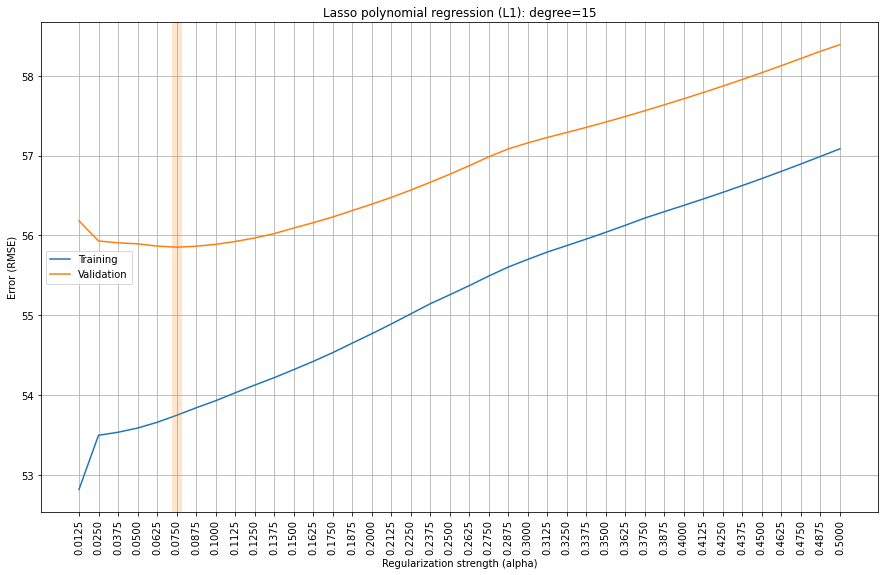

In [30]:
plot_fitting_graph(ALPHAS_no_zero, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

#### L2

In [31]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:
    if alpha !=0:
        model_ridge = Ridge(alpha=alpha,random_state=SEED, max_iter=50000)
        model_ridge.fit(X_train_full, y_train)
        y_pred_v_poly=model_ridge.predict(X_valid_full)
        y_pred_t_poly=model_ridge.predict(X_train_full)
        results = cross_validate(model_ridge, X_train_full,y_train,cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
        rmse_train.append(-np.mean(results['train_score']))
        rmse_valid.append(-np.mean(results['test_score']))
print(rmse_train, rmse_valid)

[52.91544315516396, 53.20525398519051, 53.34501350395179, 53.440277497573824, 53.51838993426095, 53.589386089174226, 53.65765425634699, 53.72530444418426, 53.79339558052645, 53.862456191461106, 53.9327304742302, 54.0043042146077, 54.07717319307303, 54.15128206646623, 54.22654722377929, 54.3028705440375, 54.38014779867892, 54.45827380817419, 54.537145585626355, 54.616664209738474, 54.69673588575724, 54.77727248380254, 54.85819174046967, 54.93941724481242, 55.02087828848356, 55.10250963299147, 55.18425122937907, 55.26604791386929, 55.34784909510772, 55.42960844326549, 55.51128358760667, 55.59283582662059, 55.674229853107214, 55.755433495435284, 55.83641747540173, 55.91715518259157, 55.99762246479169, 56.077797433794004, 56.157660285793305, 56.23719313551824] [55.863265867491194, 55.84252626991422, 55.82138498590935, 55.80769886562003, 55.80278139126873, 55.80622329360216, 55.81722999257503, 55.83497508369644, 55.858695111993065, 55.88770962254896, 55.92141884948944, 55.959295283658264, 5

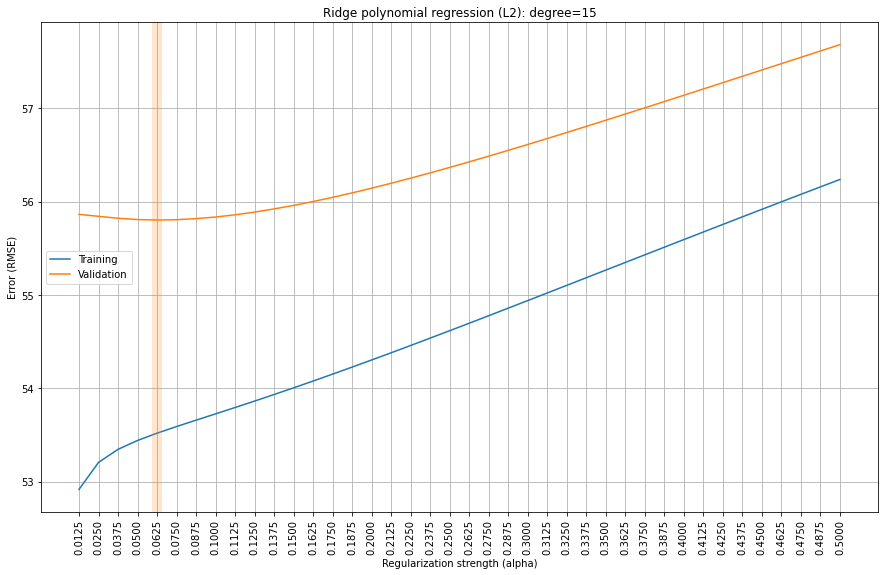

In [32]:
plot_fitting_graph(ALPHAS_no_zero, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2): degree=15')

#### Summary
As the value of alpha increases, the model complexity reduces. Although high values of alpha reduce overfitting, significantly high values can cause underfitting as well. For the same values of alpha, the coefficients of lasso regression are smaller as compared to that of ridge regression. With ridge, all the variables increase together, and with lasso, it is only a few that get increased (others turn 0). This has an additional regularizing effect.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [33]:
n_nonzero_lasso = []
for alpha in ALPHAS:
    if alpha !=0:
        model_lasso = Lasso(alpha=alpha,random_state=SEED, max_iter=50000)
        model_lasso.fit(X_train_full, y_train)
        y_pred_v_poly=model_lasso.predict(X_valid_full)
        y_pred_t_poly=model_lasso.predict(X_train_full)
        lasso_coef = model_lasso.coef_
        non_zero_n = np.count_nonzero(lasso_coef)
        n_nonzero_lasso.append(non_zero_n)
        
print(n_nonzero_lasso)

[14, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


#### L2

In [34]:
n_nonzero_ridge = []
for alpha in ALPHAS:
    if alpha !=0:
        model_ridge = Ridge(alpha=alpha,random_state=SEED, max_iter=50000)
        model_ridge.fit(X_train_full, y_train)
        y_pred_v_poly=model_ridge.predict(X_valid_full)
        y_pred_t_poly=model_ridge.predict(X_train_full)
        ridge_coef = model_ridge.coef_
        non_zero_n = np.count_nonzero(ridge_coef)
        n_nonzero_ridge.append(non_zero_n)
        
print(n_nonzero_ridge)

[54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267]


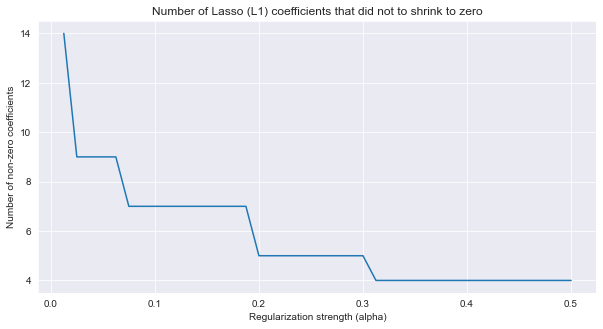

In [35]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
sns.lineplot(y=n_nonzero_lasso,x=ALPHAS_no_zero)
plt.xlabel("Regularization strength (alpha)")
plt.ylabel("Number of non-zero coefficients")
plt.title("Number of Lasso (L1) coefficients that did not to shrink to zero")
plt.show()

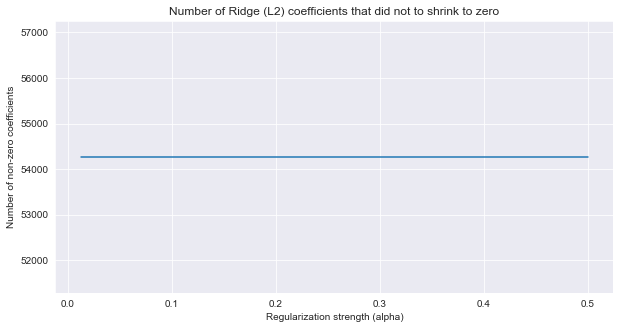

In [36]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
sns.lineplot(y=n_nonzero_ridge,x=ALPHAS_no_zero)
plt.xlabel("Regularization strength (alpha)")
plt.ylabel("Number of non-zero coefficients")
plt.title("Number of Ridge (L2) coefficients that did not to shrink to zero")
plt.show()

#### Summary
Lasso performs feature selection by shrinking to 0 coefficients of non-influential features. As the value of alpha increases from 0, it penalizes, causing the model, to decrease the value of coefficients in order to reduce loss. We can see the visualisation of this process above: with the increase of the alpha number of non-zero coefficients decreases from 14 to 4.
Unlike Lasso, Ridge never sets the value of a coefficient to absolute zero. This is why we can see a constant number of non-zero coefficients for all alpha values in L2.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [37]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

In [54]:
# Lasso without scaling
lasso = Lasso(random_state=SEED, max_iter=50000)
lasso.fit(X_hw, y_hw)
y_pred = lasso.predict(X_hw)
rmse = np.sqrt(mean_squared_error(y_pred, y_hw))
print("RMSE : ", rmse)
print("Lasso coefficients (no scaling) : ", lasso.coef_)

RMSE :  6.470777411626898
Lasso coefficients (no scaling) :  [ 0.         -0.00018907 -0.01727527]


In [55]:
# Scaling of X_hw
scaler = StandardScaler()
X_hw_s = scaler.fit_transform(X_hw)
for i in range(X_hw_s.shape[1]):
    print(f'Min of feature {i}: {min(X_hw_s[:, i]):.2f}, max: {max(X_hw_s[:, i]):.2f}')

Min of feature 0: -1.49, max: 1.83
Min of feature 1: -1.66, max: 1.54
Min of feature 2: -2.14, max: 2.24


In [56]:
# Lasso with scaling
lasso.fit(X_hw_s,y_hw)
y_pred_s = lasso.predict(X_hw_s)
rmse_s = np.sqrt(mean_squared_error(y_pred_s, y_hw))
print("RMSE : ", rmse_s)
print("Lasso coefficients (with scaling) : ", lasso.coef_)

RMSE :  4.144984286583876
Lasso coefficients (with scaling) :  [ 4.14379392  0.         -0.        ]


#### L2

In [57]:
# Ridge without scaling
ridge = Ridge(random_state=SEED, max_iter=50000)
ridge.fit(X_hw, y_hw)
y_pred = ridge.predict(X_hw)
rmse = np.sqrt(mean_squared_error(y_pred, y_hw))
print("RMSE : ", rmse)
print("Ridge coefficients (no scaling) : ", ridge.coef_)

RMSE :  6.3143281404058245
Ridge coefficients (no scaling) :  [ 6.99982104e+00 -1.72605237e-04 -1.74743260e-02]


In [58]:
# Ridge with scaling
ridge.fit(X_hw_s, y_hw)
y_pred_s = ridge.predict(X_hw_s)
rmse_s = np.sqrt(mean_squared_error(y_pred_s, y_hw))
print("RMSE : ", rmse_s)
print("Ridge coefficients (with scaling) : ", ridge.coef_)

RMSE :  3.976916509994631
Ridge coefficients (with scaling) :  [ 5.01589763  0.11824753 -0.59994834]


#### Summary
Lasso and Ridge, with the scaling of features, show better results than without scaling. The reason is that these models get affected by outliers very severely. In our case study, standardisation with StandardScaler transformed extreme values from X_hw (feature 2) and, thus, improved model performance (lower RMSE).